# Quantum Edge Detection

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.visualization import plot_histogram
from PIL import Image

import cv2

## Quantum Probability Image Encoding (QPIE)
	
The QPIE representation uses the probability amplitudes of a quantum state to store pixel values of a classical image. Quantum amplitude encoding loads classical data into a quantum state by using the data values as amplitudes of a superposition state.

For example, with a 2×2 matrix the quantum state is:

$$ |\psi\rangle = c_0|00\rangle + c_1|01\rangle + c_2|10\rangle + c_3|11\rangle $$

Each coefficient $c_i$ corresponds to a pixel intensity after normalization, calculated as:

$$ c_i = \frac{I_{yx}}{\sqrt{\sum I_{yx}^2}} $$

Here, $I_{yx}$ is the pixel intensity at position $(y, x)$, and the denominator normalizes the quantum state.

OR generalizing for $n$-qubits, we have,


$$ |Img\rangle = \sum_{i=0}^{2^n-1} c_i |i\rangle $$

This formula represents a quantum state, often used in the context of encoding an image, where:
-   $|Img\rangle$ is the quantum state representing the image.
-   $n$ is the number of qubits used.
-   The sum $\sum$ goes from $i=0$ to $2^n-1$, covering all possible computational basis states for $n$ qubits.
-   $c_i$ are the complex amplitudes associated with each basis state $|i\rangle$. The square of the magnitude of $c_i$ (i.e., $|c_i|^2$) gives the probability of measuring the state $|i\rangle$.
-   $|i\rangle$ represents the $i$-th computational basis state (e.g., for $n=2$, these would be $|00\rangle, |01\rangle, |10\rangle, |11\rangle$).


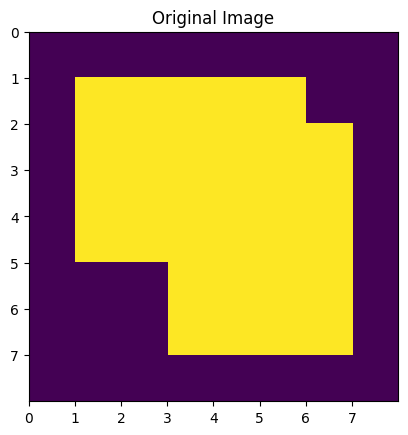

In [2]:
# A 8x8 binary image represented as a numpy array
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

In [3]:
# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [4]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    return np.array(image_norm)

- float for error reduction

In [5]:
def amplitude_encode1(img_data):

    img_data_float = img_data.astype(np.float64)
    rms = np.sqrt(np.sum(img_data_float**2))

    image_norm = img_data_float.flatten() / rms
    return image_norm


# Quantum Hadamard Edge Detection (QHED)

The Hadamard gate $H$ has the following operation on the state of a qubit:

$$ |0\rangle \rightarrow \frac{|0\rangle + |1\rangle}{\sqrt{2}} $$
$$ |1\rangle \rightarrow \frac{|0\rangle - |1\rangle}{\sqrt{2}} $$
It creates an equal superposition of the basis states when applied to $|0\rangle$ or $|1\rangle$.


For two neighboring pixels, the bit-strings can be written as $|b_{n-1}b_{n-2}...b_10\rangle$ and $|b_{n-1}b_{n-2}...b_11\rangle$ 

To optain this we apply a H gate on the LSB.
The operation $I_{2^{n-1}} \otimes H_0$ can be represented by the matrix:

$$ I_{2^{n-1}} \otimes H_0 = \frac{1}{\sqrt{2}} \begin{pmatrix}
1 & 1 & 0 & 0 & \dots & 0 & 0 \\
1 & -1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 1 & \dots & 0 & 0 \\
0 & 0 & 1 & -1 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 1 & 1 \\
0 & 0 & 0 & 0 & \dots & 1 & -1
\end{pmatrix} $$

This matrix describes applying the Hadamard gate ($H_0$) to the last qubit (qubit 0) while leaving the other $n-1$ qubits unchanged (represented by the identity matrix $I_{2^{n-1}}$). The $\otimes$ symbol denotes the tensor product.

When this operation is applied to a state vector with amplitudes $c_0, c_1, c_2, \dots, c_{N-1}$ (where $N=2^n$), the transformation is as follows:

$$ (I_{2^{n-1}} \otimes H_0) \begin{pmatrix} c_0 \\ c_1 \\ c_2 \\ c_3 \\ \vdots \\ c_{N-2} \\ c_{N-1} \end{pmatrix} \rightarrow \frac{1}{\sqrt{2}} \begin{pmatrix} c_0 + c_1 \\ c_0 - c_1 \\ c_2 + c_3 \\ c_2 - c_3 \\ \vdots \\ c_{N-2} + c_{N-1} \\ c_{N-2} - c_{N-1} \end{pmatrix} $$


Following these stpes we have gradient between the pixel intensities of neighboring pixels in the form of 
where i is even ( 0 & 1 ,2  2 & 3 ).

For detecting horizontal boundaries between odd-pixel-pairs ( 1 & 2 ,3 & 4 ) apply same steps on $(c_1, c_2, c_3, \dots, c_{N-1}, c_0)^T$.




In [6]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb 

N = 2**total_qb 


D2n_1 = np.roll(np.identity(N), 1, axis=1)

print(f"The shape of the D2n_1 matrix is: {D2n_1.shape}\n")

print("D2n_1 matrix (summarized view for large matrix):")

print(D2n_1) # amplitude permutation unitary for later use

The shape of the D2n_1 matrix is: (128, 128)

D2n_1 matrix (summarized view for large matrix):
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [7]:
image_norm_h = amplitude_encode(image)

print(image_norm_h)
# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.1796053 0.1796053 0.1796053 0.1796053 0.1796053
 0.        0.        0.        0.1796053 0.1796053 0.1796053 0.1796053
 0.1796053 0.1796053 0.        0.        0.1796053 0.1796053 0.1796053
 0.1796053 0.1796053 0.1796053 0.        0.        0.1796053 0.1796053
 0.1796053 0.1796053 0.1796053 0.1796053 0.        0.        0.
 0.        0.1796053 0.1796053 0.1796053 0.1796053 0.        0.
 0.        0.        0.1796053 0.1796053 0.1796053 0.1796053 0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ]


In [8]:
# number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


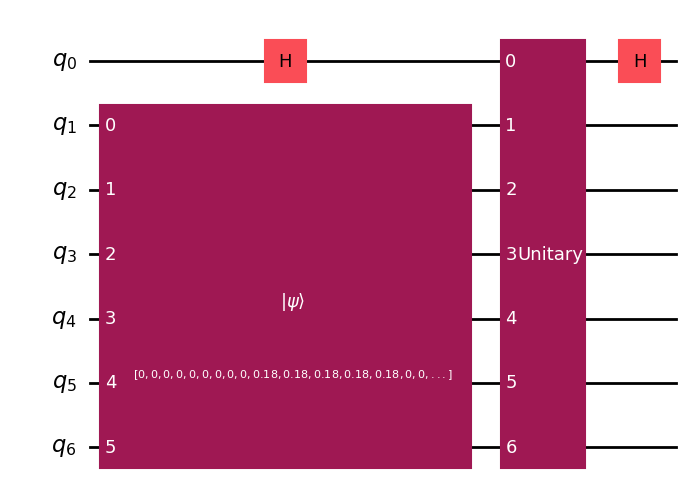

In [9]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
#qc_h.measure_all()
qc_h.draw('mpl', fold=-1)

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
#qc_v.measure_all()





In [10]:
simulator = AerSimulator(method='statevector')


TQc_h = transpile(qc_h, simulator, optimization_level=3)
TQc_v = transpile(qc_v, simulator, optimization_level=3)


TQc_h.save_statevector()
TQc_v.save_statevector()

job_statevector_h = simulator.run(TQc_h, shots=1)  
job_statevector_v = simulator.run(TQc_v, shots=1)


statevector_h = job_statevector_h.result().get_statevector()
statevector_v = job_statevector_v.result().get_statevector()

counts_h = job_statevector_h.result().get_counts()
counts_v = job_statevector_v.result().get_counts()

# Print results
print("\nHorizontal Scan Statevector:")
print(statevector_h)
print("\nHorizontal Scan Counts:")
print(counts_h)
print("\nVertical Scan Statevector:")
print(statevector_v)
print("\nVertical Scan Counts:")
print(counts_v)


Horizontal Scan Statevector:
Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              8.98026510e-02-1.09976529e-17j,
             -8.98026510e-02+1.09976529e-17j,
              1.79605302e-01-1.09976529e-17j,
             -1.38777878e-17+1.09976529e-17j,
              1.79605302e-01-1.09976529e-17j,
    

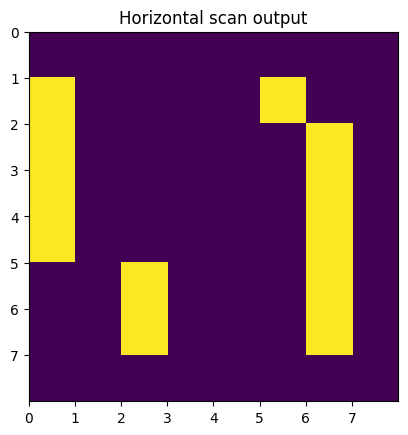

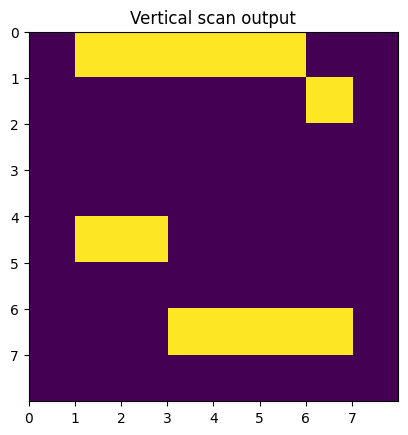

In [11]:

threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)


edge_scan_h = np.abs(np.array([1 if threshold(statevector_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(statevector_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

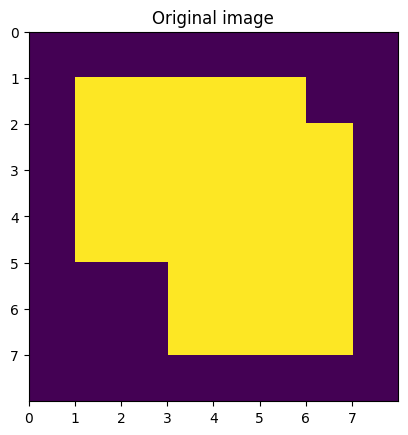

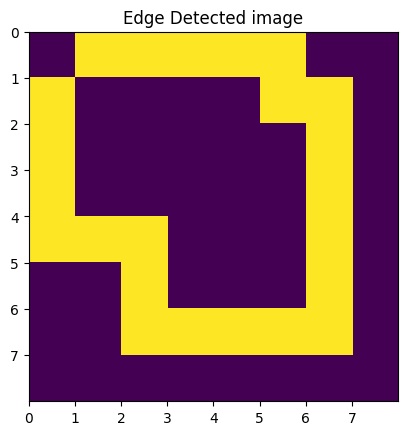

In [12]:
edge_scan_sim = edge_scan_h | edge_scan_v

plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

# for a 256 x 256 imagine

In [ ]:
img_path_blood = "/Users/romantudorgeorge/Documents/UTCN/An3Sem2/QIP/blood1_resized.bmp"

img_cameraman = '/Users/romantudorgeorge/Documents/UTCN/An3Sem2/IP/PI-L9/cameraman.bmp'
cameraman_r = "/Users/romantudorgeorge/Documents/UTCN/An3Sem2/QIP/cameraman1.bmp"


img = cv2.imread(img_path_blood, cv2.IMREAD_GRAYSCALE)


- low pass filter

In [14]:
sigma = 0.5
ksize = 5  
blurred = cv2.GaussianBlur(img, (ksize, ksize), sigma)

-  split imaigne 

In [15]:
def split_numpy_image(image_np: np.ndarray) -> np.ndarray:
    if not isinstance(image_np, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    if image_np.ndim != 2:
        raise ValueError("Input NumPy array must be 2-dimensional (grayscale image).")

    height, width = image_np.shape
    
    if width != 256 or height != 256:
        raise ValueError(f"Image must be 256x256 pixels, but got {height}x{width} pixels.")
    
    parts = []
    part_size = 32
    num_blocks_rows = height // part_size  
    num_blocks_cols = width // part_size  
    
    for i in range(num_blocks_rows):  
        for j in range(num_blocks_cols): 

            start_row = i * part_size
            end_row = start_row + part_size
            start_col = j * part_size
            end_col = start_col + part_size
            

            part_array = image_np[start_row:end_row, start_col:end_col]
            
            parts.append(part_array)
            
    return np.array(parts)

In [16]:
img_split_blood = split_numpy_image(blurred)  
print(img_split_blood[10])

[[182 182 158 ...  46  48  64]
 [184 173 143 ...  46  46  48]
 [177 156 119 ...  46  46  46]
 ...
 [166 163 164 ... 160 163 163]
 [197 193 186 ... 156 159 159]
 [212 213 210 ... 155 155 156]]


- apply qhed on the individul splited imagines 

In [17]:
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)


simulator = AerSimulator(method='statevector')

data_qub = 10  
total_qub = 11  
N = 2 ** total_qub
D2n_1 = np.roll(np.identity(N), 1, axis=1)  


edge_scans = []
for k in range(64):

    img_part = img_split_blood[k]
    
    img_h = amplitude_encode1(img_part)
    img_v = amplitude_encode1(img_part.T)
    
    # Horizontal scan circuit
    qc_h = QuantumCircuit(total_qub)
    qc_h.initialize(img_h, range(1, total_qub))
    qc_h.h(0)
    qc_h.unitary(D2n_1, range(total_qub))
    qc_h.h(0)
    
    # Vertical scan circuit
    qc_v = QuantumCircuit(total_qub)
    qc_v.initialize(img_v, range(1, total_qub))
    qc_v.h(0)
    qc_v.unitary(D2n_1, range(total_qub))
    qc_v.h(0)
    
    # Transpile and simulate
    tqc_h = transpile(qc_h, simulator, optimization_level=3)
    tqc_v = transpile(qc_v, simulator, optimization_level=3)
    tqc_h.save_statevector()
    tqc_v.save_statevector()
    job_h = simulator.run(tqc_h, shots=1)
    job_v = simulator.run(tqc_v, shots=1)
    statevector_h = job_h.result().get_statevector()
    statevector_v = job_v.result().get_statevector()
    
    # Post-process statevectors
    edge_scan_h = np.abs(np.array([0 if threshold(statevector_h[2*i+1].real) else 1
                                 for i in range(2**data_qub)])).reshape(32, 32)
    edge_scan_v = np.abs(np.array([0 if threshold(statevector_v[2*i+1].real) else 1
                                 for i in range(2**data_qub)])).reshape(32, 32).T
    
    # Combine  with bitwise AND
    edge_scan = edge_scan_h & edge_scan_v


    edge_scans.append(edge_scan)



In [18]:
def plot_image1(image_array, title):
    
    plt.figure()
    plt.imshow(image_array, cmap='gray')
    plt.title(title)
    plt.axis('off')  
    plt.show()

- result visualisation

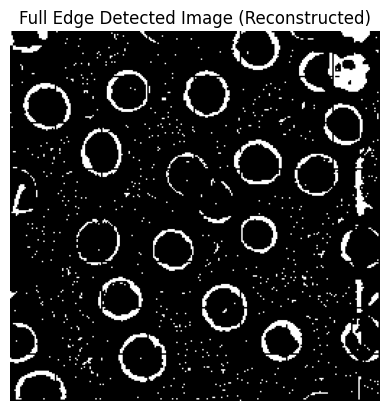

In [19]:
full_edge_image = np.zeros((256, 256), dtype=int)
for k, edge_scan in enumerate(edge_scans):
    i = k // 8  
    j = k % 8   
    full_edge_image[i*32:(i+1)*32, j*32:(j+1)*32] = edge_scan

plot_image1(full_edge_image, 'Full Edge Detected Image (Reconstructed)')

In [20]:
imgCam = cv2.imread(cameraman_r, cv2.IMREAD_GRAYSCALE)
#cv2.imshow('Img', imgCam)
#cv2.waitKey(0)

In [21]:
sigma = 0.5
ksize = 5  
blurred = cv2.GaussianBlur(imgCam, (ksize, ksize), sigma)

In [22]:
img_split_cameraman = split_numpy_image(blurred)  
print(img_split_cameraman[10])

[[176 175 176 ... 182 181 182]
 [178 178 176 ... 182 184 184]
 [176 178 178 ... 182 181 182]
 ...
 [178 179 179 ... 184 105  23]
 [174 179 180 ... 177  68  16]
 [180 181 182 ... 119  32  12]]


In [23]:
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
edge_scans = []
data_qub = 10  
total_qub = 11  
 
N = 2 ** total_qub
D2n_1 = np.roll(np.identity(N), 1, axis=1) 

simulator = AerSimulator(method='statevector')

for k in range(64):
    img_part = img_split_cameraman[k]
    

    if np.all(img_part == 0):
      
        edge_scan = np.zeros((32, 32), dtype=int)
    else:
       
        img_h = amplitude_encode1(img_part)
        img_v = amplitude_encode1(img_part.T)
        
        # Horizontal scan circuit
        qc_h = QuantumCircuit(total_qub)
        qc_h.initialize(img_h, range(1, total_qub))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qub))
        qc_h.h(0)
        
        # Vertical scan circuit
        qc_v = QuantumCircuit(total_qub)
        qc_v.initialize(img_v, range(1, total_qub))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qub))
        qc_v.h(0)
        
        # Transpile and simulate
        tqc_h = transpile(qc_h, simulator, optimization_level=3)
        tqc_v = transpile(qc_v, simulator, optimization_level=3)
        tqc_h.save_statevector()
        tqc_v.save_statevector()
        job_h = simulator.run(tqc_h, shots=1)
        job_v = simulator.run(tqc_v, shots=1)
        statevector_h = job_h.result().get_statevector()
        statevector_v = job_v.result().get_statevector()
        
        # Post-process statevectors
        edge_scan_h = np.abs(np.array([1 if threshold(statevector_h[2*i+1].real) else 0
                                     for i in range(2**data_qub)])).reshape(32, 32)
        edge_scan_v = np.abs(np.array([1 if threshold(statevector_v[2*i+1].real) else 0
                                     for i in range(2**data_qub)])).reshape(32, 32).T
        
        # Combine with bitwise AND
        edge_scan = edge_scan_h & edge_scan_v
    
    # Append the result 
    edge_scans.append(edge_scan)

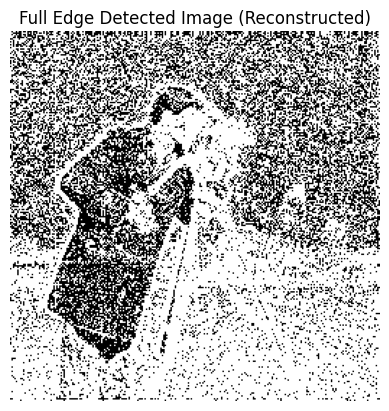

In [24]:
full_edge_image = np.zeros((256, 256), dtype=int)
for k, edge_scan in enumerate(edge_scans):
    i = k // 8  
    j = k % 8   
    full_edge_image[i*32:(i+1)*32, j*32:(j+1)*32] = edge_scan

plot_image1(full_edge_image, 'Full Edge Detected Image (Reconstructed)')